# milner video proj

In [1]:
# Import all the things.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Config
XLABEL = 'Time (s)'
YLABEL = 'Speed (m/s)'

In [3]:
RESULTS = []
STDEVS = []

## Helper funcs

In [4]:
def get_crests(df, wave_filter=None, use_troughs=False, verbose=False):
    if wave_filter is not None:
        df = wave_filter.apply_x_filter(df, verbose)
    points = df[YLABEL].tolist() # Store a list of the points from the sample.
    crests = []
    ends_of_cycles = []

    for index, point in enumerate(points): # Go through each point one by one
        try:
            if point > 0 and points[index+1] < 0:
                ends_of_cycles.append(index)
        except IndexError:
            pass


    raw_cycles = [sl.tolist() for sl in np.split(points, ends_of_cycles)][:-1]
    cycles = [x for x in raw_cycles if x != []]
    for cycle in cycles:
        crests.append(max(cycle) if use_troughs is False else min(cycle))
    if wave_filter is not None:
        crests = wave_filter.apply_y_filter(crests)
    return crests

In [5]:
def big_scary_plot(smpls):
    fig = plt.figure(figsize=[18,6])

    for frame in smpls.keys():
        fr = smpls[frame]
        plt.plot(fr[XLABEL], fr[YLABEL])

    plt.legend(smpls.keys())
    plt.grid(visible=True)
    plt.show()

In [6]:
def plot_trial_dataframe(df, name=None, xlabel=None, ylabel=None, yerr=None, graph_type=None):
    df.plot(
        x=xlabel or XLABEL,
        y=ylabel or YLABEL,
        kind=graph_type or 'line',
        figsize=(24,6),
        grid=True,
        title=name,
        xlabel=xlabel or XLABEL,
        ylabel=ylabel or YLABEL,
        yerr=yerr or None
    )

In [7]:
def filter_points(crests_list):
    abs_cr = np.absolute(crests_list)
    filtered_cr = sorted(abs_cr, reverse=True)
    return filtered_cr[0:5]

## Main computation

In [8]:
def read_in_trials(tlabel):
    deg_samples = {}
    for trial in range(1, 11):
        trial_id = f"{tlabel}-t{trial}"
        csv_name = f"{trial_id}.csv"
        try:
            df = pd.read_csv(csv_name)
            df.drop(df[df[XLABEL] == '#NUM!'].index, inplace=True)
            df.drop(df[df[YLABEL] == '#NUM!'].index, inplace=True)
            df.drop(df[df['Frequency (Hz)'] == '#NUM!'].index, inplace=True)
            df[XLABEL] = pd.to_numeric(df[XLABEL])
            df[YLABEL] = pd.to_numeric(df[YLABEL])
            deg_samples[trial_id] = df
        except FileNotFoundError:
            print(f'File {csv_name} not found!')
    return deg_samples

In [9]:
def run_wave_math(sample_dict, wfs_table, label, verbose=[]):
    avglist = []
    for tdf_key in sample_dict.keys():
        print(tdf_key)
        tdf = sample_dict[tdf_key]
        try:
            wf = wfs_table[tdf_key]
        except KeyError:
            wf = None
        is_verbose = len(avglist) + 1 in verbose
        crestslist = get_crests(tdf, wave_filter=wf, verbose=is_verbose)
        troughslist = get_crests(tdf, wave_filter=wf, use_troughs=True, verbose=is_verbose)

        print(crestslist)
        print(troughslist)
        tdf_crests = filter_points(crestslist)
        tdf_troughs = filter_points(troughslist)

        tdf_crests.extend(tdf_troughs)

        tdf_avg_v = np.average(tdf_crests)
        avglist.append(tdf_avg_v)
        print("trial avg v:", tdf_avg_v)
        print("~~~~~~")

    trials_avg = np.average(avglist)
    trials_stdev = np.std(avglist)
    RESULTS.append(trials_avg)
    STDEVS.append(trials_stdev)

    print(f"{label} avg v:", trials_avg)
    print(f"{label} trial stdev:", trials_stdev)
    return avglist, trials_stdev

In [10]:
class WaveFilter():
    def __init__(self, x_min=0, x_max=4096, y_min=-4096, y_max=4096):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        
    def apply_x_filter(self, df, verbose):
        df.drop(df[df[XLABEL] < self.x_min].index, inplace=True)
        df.drop(df[df[XLABEL] > self.x_max].index, inplace=True)
        
        if verbose:
            plot_trial_dataframe(df)
        return df

    def apply_y_filter(self, crestlist):
        return [y for y in crestlist if y <= self.y_max and y >= self.y_min]

In [11]:
def generate_trial_graph(results, stdev):
    trial_df_data = {
        'Trial': range(1, 11),
        'Velocity': results
    }
    trial_df = pd.DataFrame(data=trial_df_data)
    plot_trial_dataframe(trial_df, graph_type='scatter', xlabel='Trial', ylabel='Velocity', yerr=stdev)

In [12]:
def run_deg_computation(deg, wf_table={}, verbose=[]):
    SAMPLES = read_in_trials(deg)
    big_scary_plot(SAMPLES)
    for item in verbose:
        plot_trial_dataframe(SAMPLES[f'{deg}-t{item}'])
    avglist, stdev = run_wave_math(SAMPLES, wf_table, f'{deg}deg', verbose=verbose)
    generate_trial_graph(avglist, stdev)

## 5

In [13]:
WFS_FIVE_DEG = {
    '5-t1': WaveFilter(x_min=6, x_max=20),
    '5-t2': WaveFilter(x_min=8, x_max=18),
    '5-t3': WaveFilter(x_min=10, x_max=25)
}

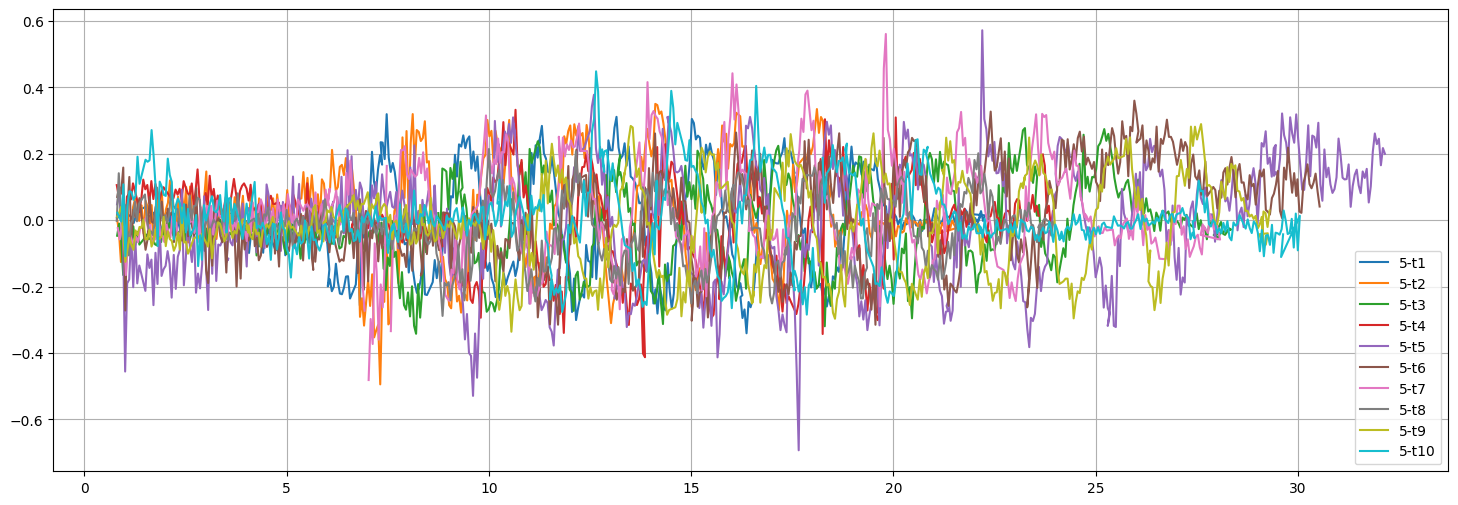

5-t1
[0.3191663278, 0.2552401866, 0.2838409675, 0.002553512093, 0.3111252115, 0.3048274784, 0.246904739, 0.2215360388]
[-0.2570269506, -0.2255276249, -0.2413996915, -0.3009049041, -0.1772660496, -0.2814530636, -0.3407421564, -0.2601129899]
trial avg v: 0.29144402364
~~~~~~
5-t2
[0.3194702414, 0.008171471942, 0.3016939367, 0.2887675127, 0.3501583324, 0.3234497809, 0.02700290694]
[0.01503381794, -0.2784905902, -0.05992905701, -0.2281647426, -0.310174278, -0.2615045003, -0.2712369522]
trial avg v: 0.29331108674000006
~~~~~~
5-t3
[0.2376906728, 0.08899528861, 0.06115700272, 0.03155507253, 0.1964004617, 0.2092323016, 0.1813708234, 0.2238928588, 0.1921777312, 0.2057221391, 0.0142660707, 0.2773126328, 0.04598025806]
[-0.2751438047, -0.2733072211, -0.07225497833, -0.001111386403, -0.01946925808, -0.312947495, -0.2430177266, -0.04393546422, -0.3196866996, -0.2957601475, -0.2183467465, -0.0651656994, -0.1873674675]
trial avg v: 0.2630695973
~~~~~~
5-t4
[0.1055168919, 0.1527427859, 0.1336545614, 

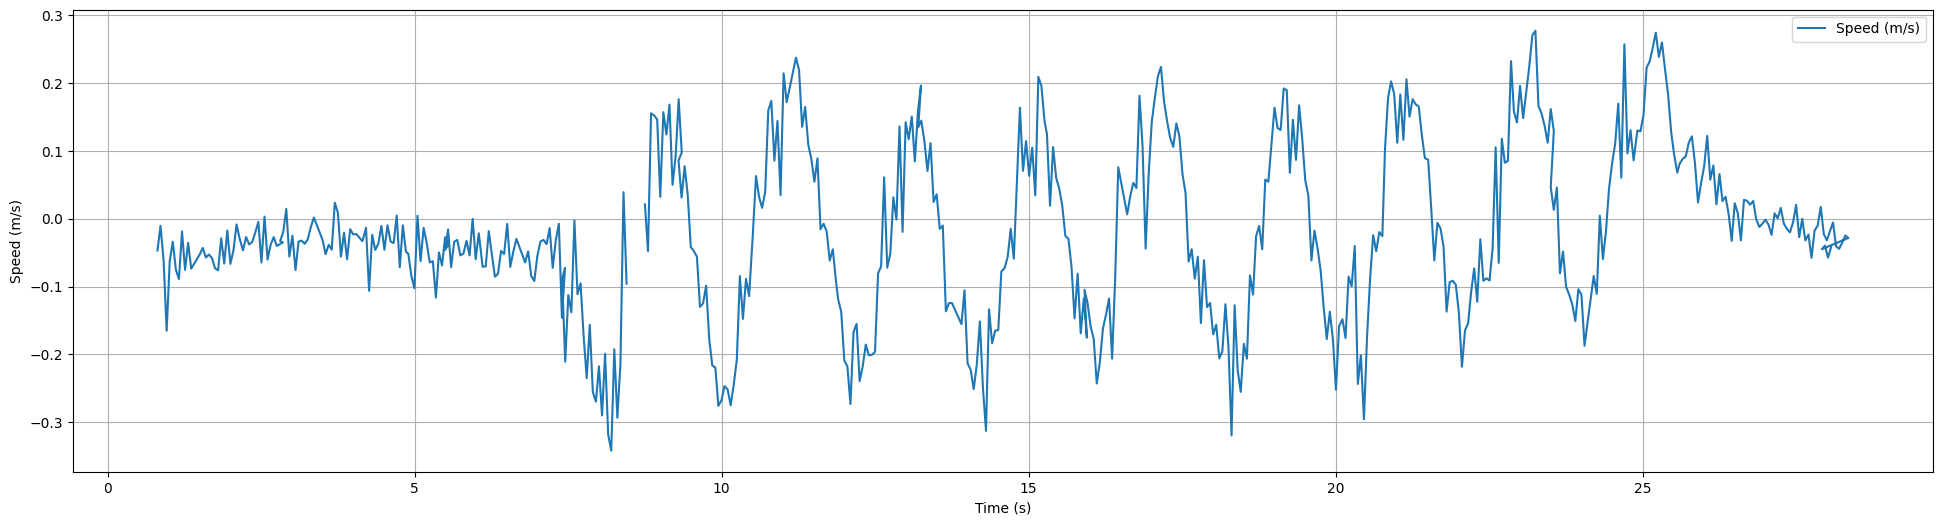

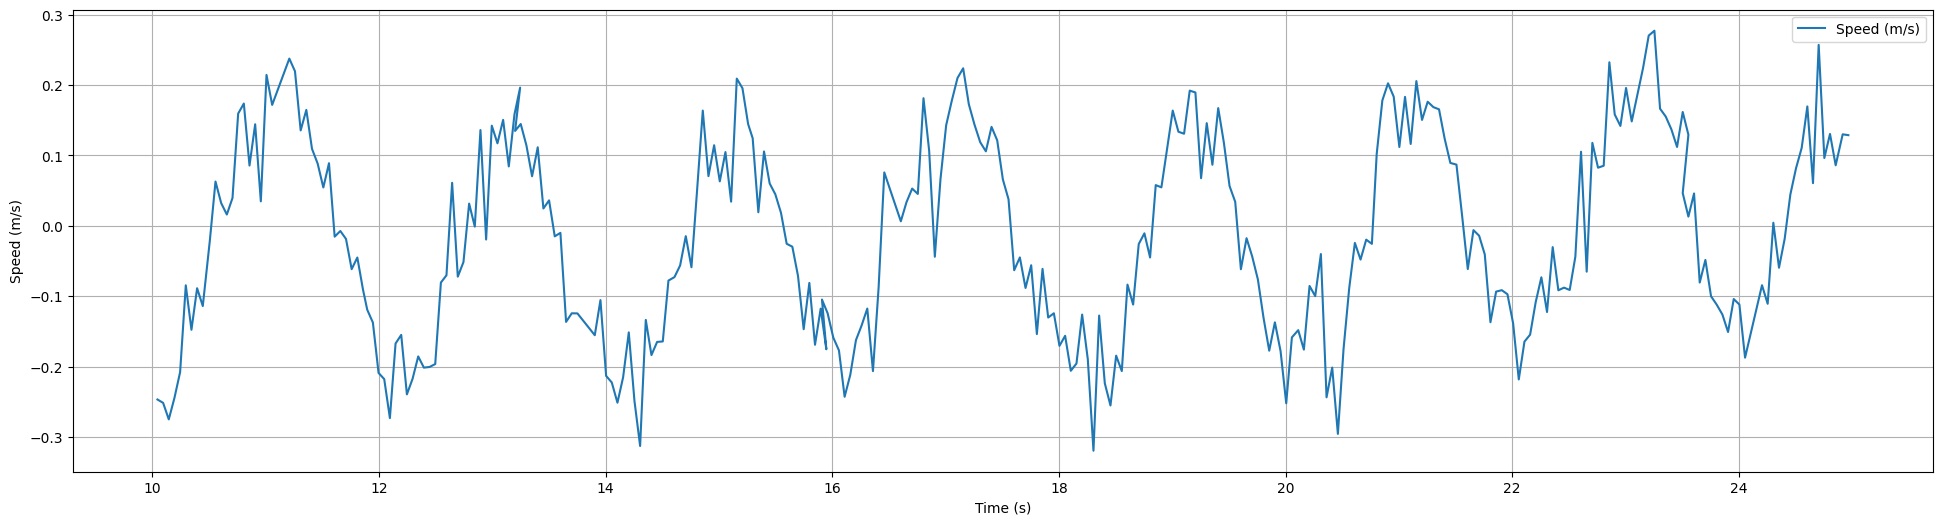

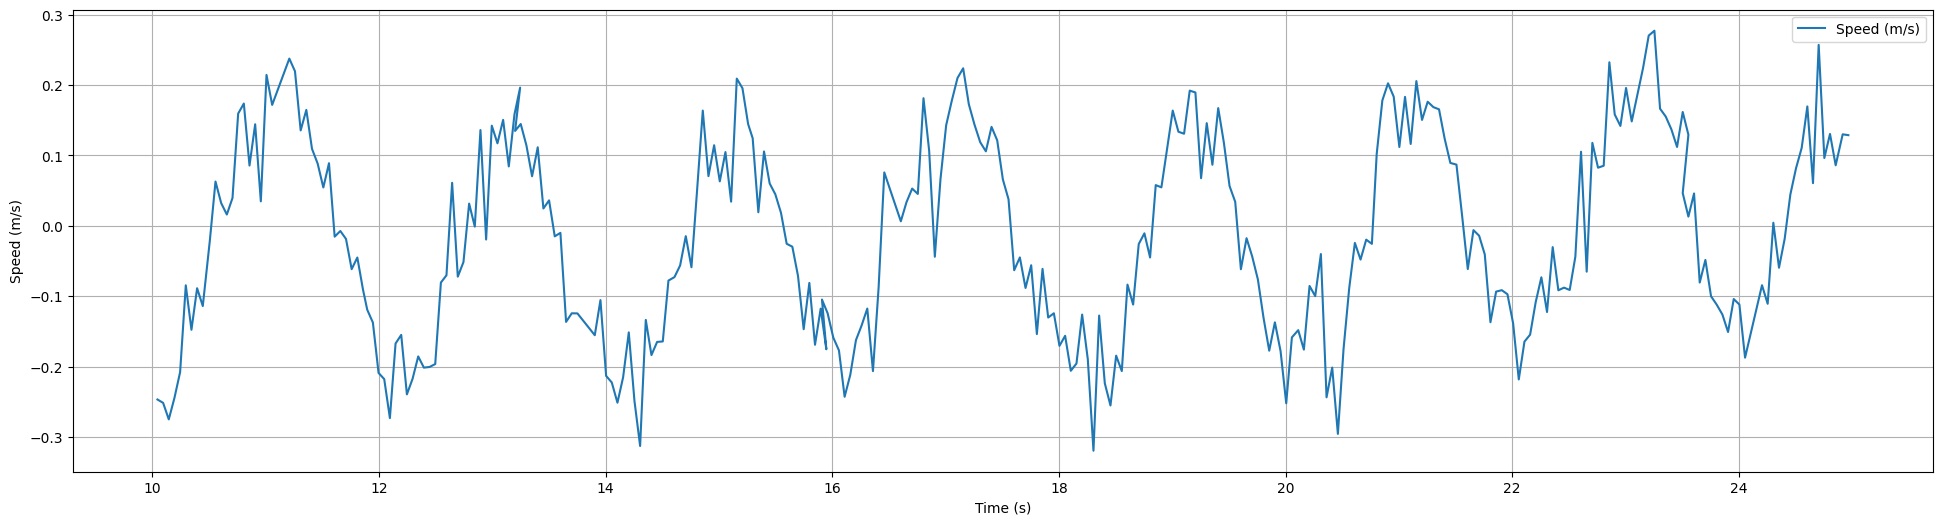

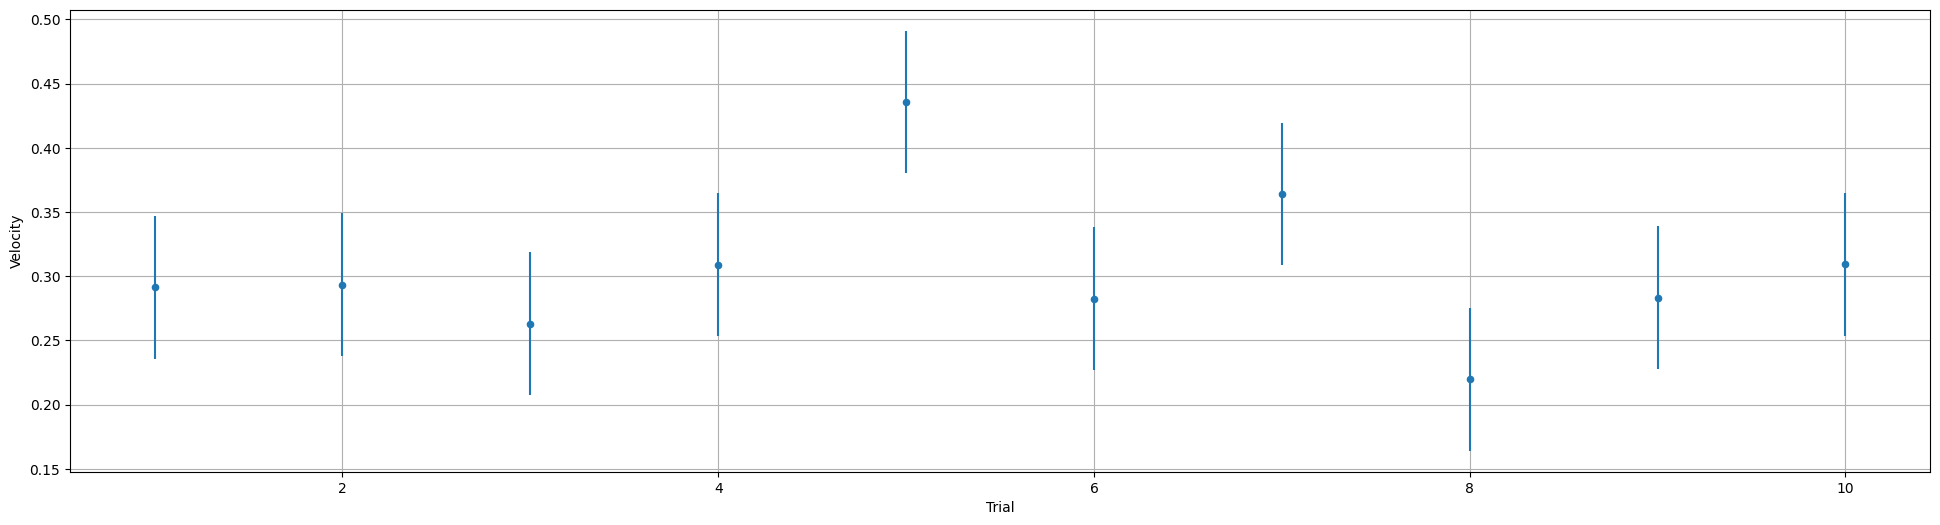

In [14]:
run_deg_computation(5, wf_table=WFS_FIVE_DEG, verbose=[3])

## 10

In [15]:
WFS_TEN_DEG = {
}

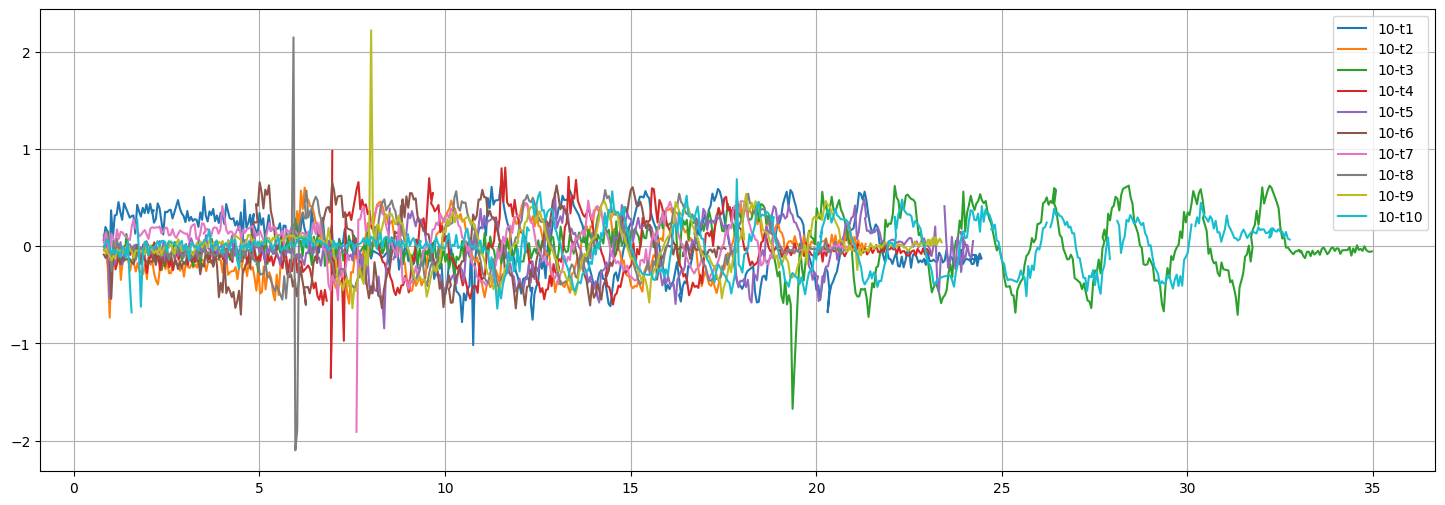

10-t1
[0.1968151627, 0.5056450418, 0.2893721623, 0.06148497109, 0.2135473827, 0.06058796749, 0.1068938791, 0.002438945307, 0.05856625658, 0.133207443, 0.06008974058, 0.004440843089, 0.03063770888, 0.0002045542282, 0.6304053262, 0.5693522943, 0.04204222827, 0.5656088148, 0.5883366172, 0.5767926954, 0.5598343165]
[0.06027809056, -0.3679855714, -0.0647430962, -0.04814861955, -0.1852423855, -0.04185912546, -0.1325907678, -0.1989162046, -0.123278433, -0.2169859747, -0.1143597401, -0.2412837675, -0.5144653005, -0.7808562914, -1.017745978, -0.756355697, -0.6176617586, -0.003909914544, -0.5700597142, -0.5794981433, -0.680809561]
trial avg v: 0.67839250339
~~~~~~
10-t2
[0.6011466456, 0.4578595203, 0.4685686173, 0.006154927626, 0.4520066244, 0.403410838, 0.3904623733, 0.4352299529, 0.1024274305, 0.03449611275, 0.110191617, 0.04788608479, 0.05144817921, 0.1174066738, 0.1112575704, 0.196710058, 0.2292064223, 0.06187858743]
[-0.7342521141, -0.5921109548, -0.4617693772, -0.5256542441, -0.01201793617

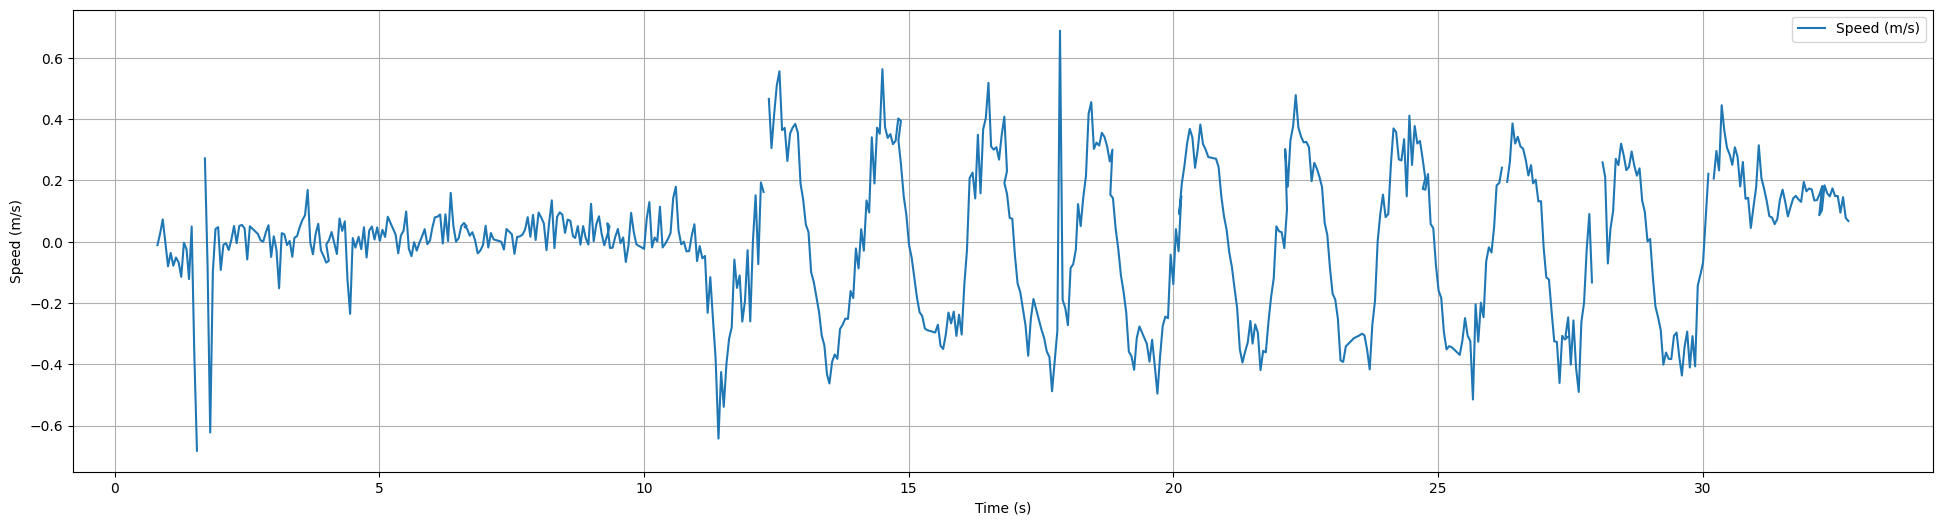

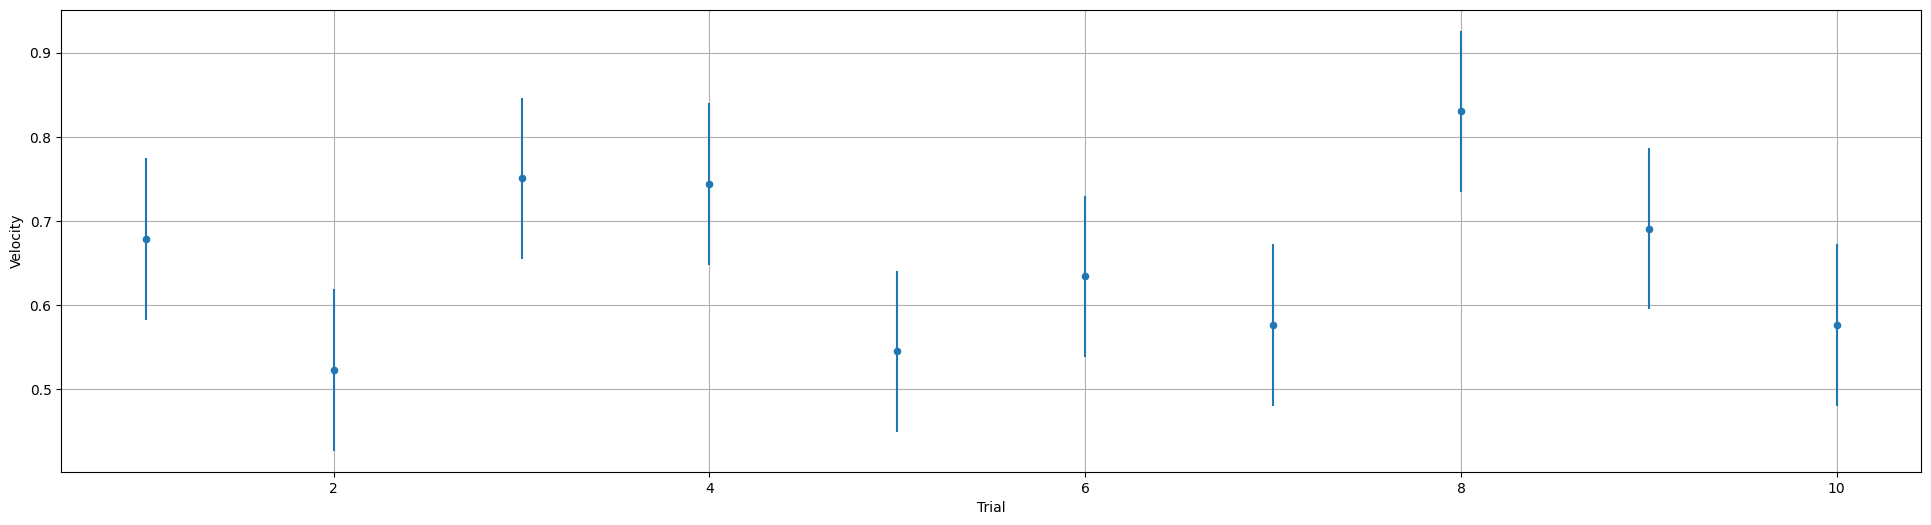

In [16]:
run_deg_computation(10, wf_table=WFS_TEN_DEG, verbose=[10])

## 15

In [17]:
WFS_FIFTEEN_DEG = {
    '15-t1': WaveFilter(x_min=5, x_max=15),
    '15-t2': WaveFilter(x_min=7.5, x_max=17.5),
    '15-t3': WaveFilter(x_min=6.5, x_max=17.5),
    '15-t4': WaveFilter(x_min=7.5, x_max=17.5),
    '15-t5': WaveFilter(x_min=7.5, x_max=17.5),
    '15-t6': WaveFilter(x_min=5, x_max=20),
    '15-t7': WaveFilter(x_min=6, x_max=16.5),
    '15-t8': WaveFilter(x_min=4, x_max=15),
    '15-t9': WaveFilter(x_min=5, x_max=15),
    '15-t10': WaveFilter(x_min=6, x_max=15.5),
}

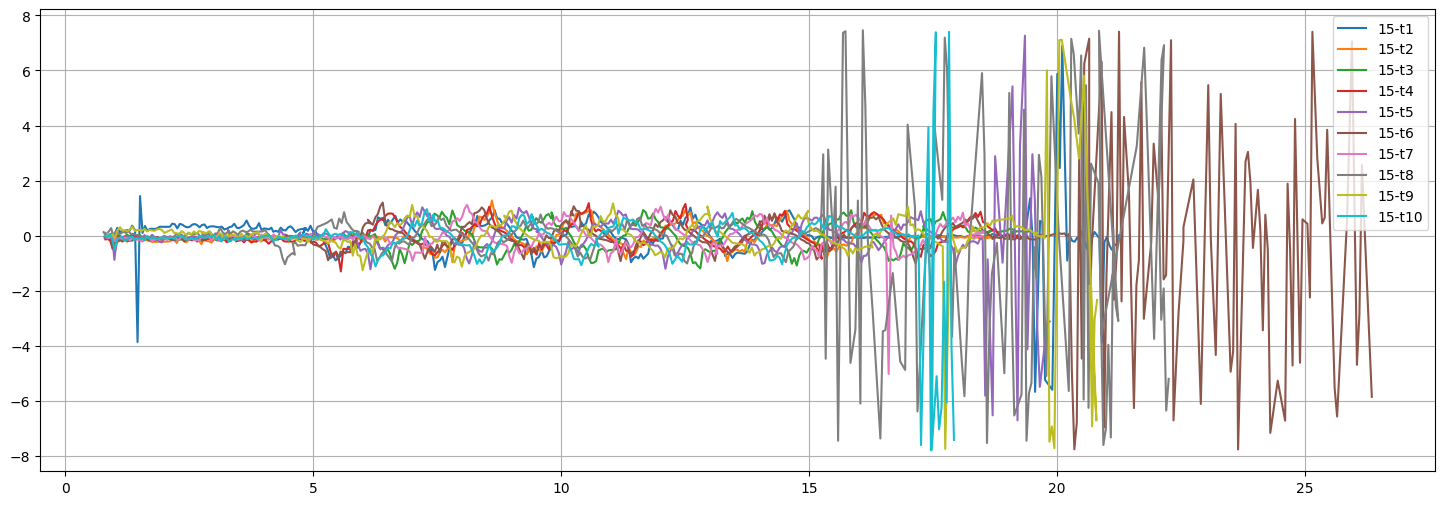

15-t1
[0.164009822001236, 0.718002866257204, 0.926325329548769, 0.876216068295002, 1.02243926429304, 0.919278204133096]
[0.0037595367041953, -0.894684787174822, -1.23924914221233, -1.13893138900655, -0.963448216582932, -0.806701173155138]
trial avg v: 0.9505276440658884
~~~~~~
15-t2
[-0.12769134687741, 1.28103711241787, 0.927680646858786, 0.93359107784746, 0.902420878726153, 0.809774130044592]
[-0.959862384437034, -0.0303728200978126, -0.668886988630257, -0.8504112558757, -0.921390685947077, -0.816178756588473]
trial avg v: 0.9071233917373401
~~~~~~
15-t3
[0.913475003456505, 0.846979384301201, 0.931422151468675, 0.890663336414084, 0.928339003437357]
[-1.20132568682913, -1.04325974796349, -0.989472198292307, -1.18484987685475, -1.08009051811442]
trial avg v: 1.0009876907131918
~~~~~~
15-t4
[-0.0855510501429668, 1.05519131748027, 1.18381613933723, 1.15530241853596, 0.905229520287991, 0.114041287348126, 0.855705265724429]
[-0.593071281553432, -0.0370667328535479, -0.687792047231035, -0.75

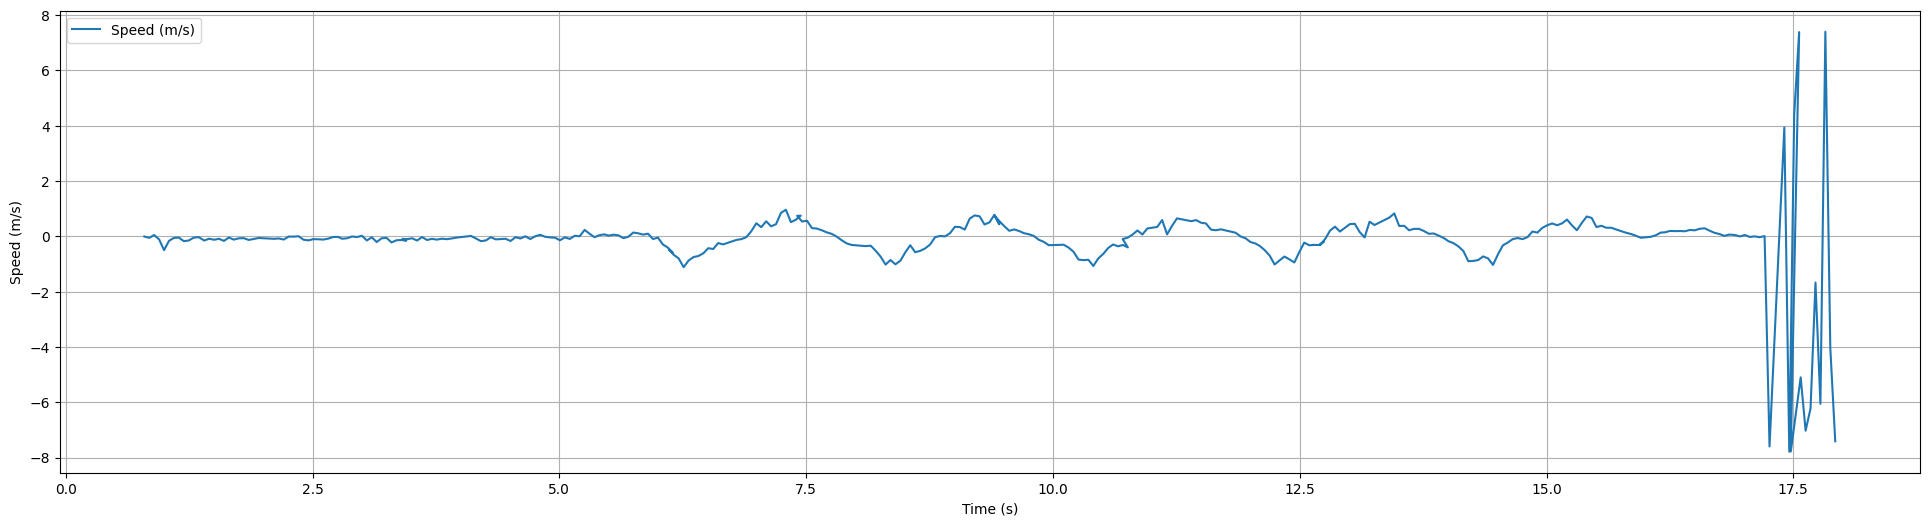

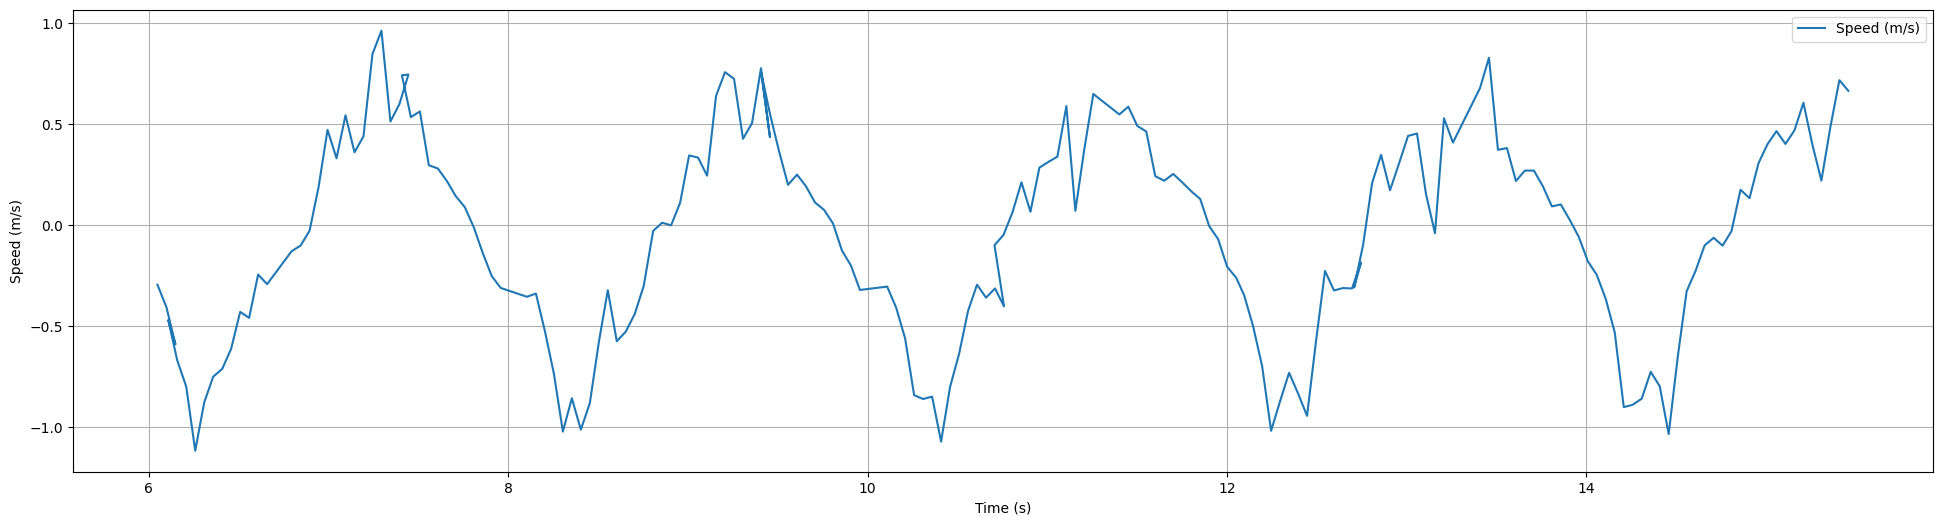

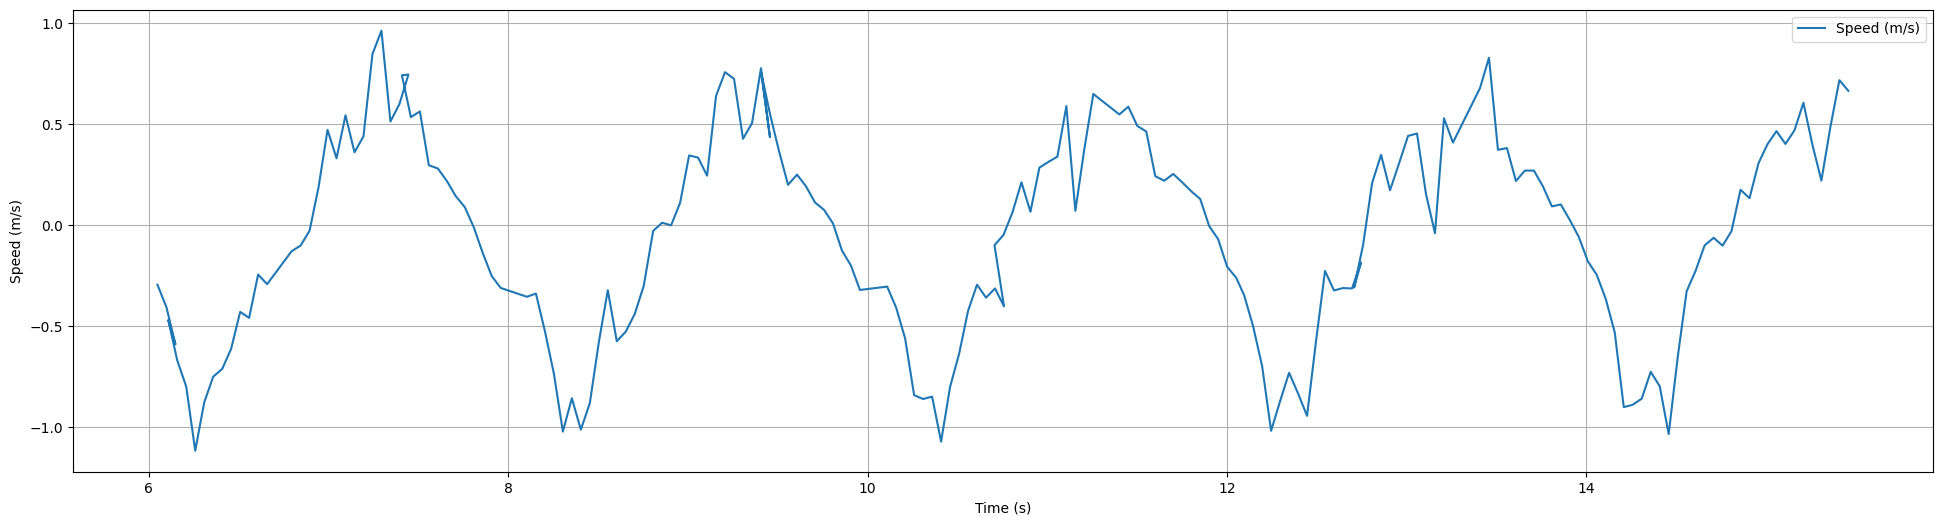

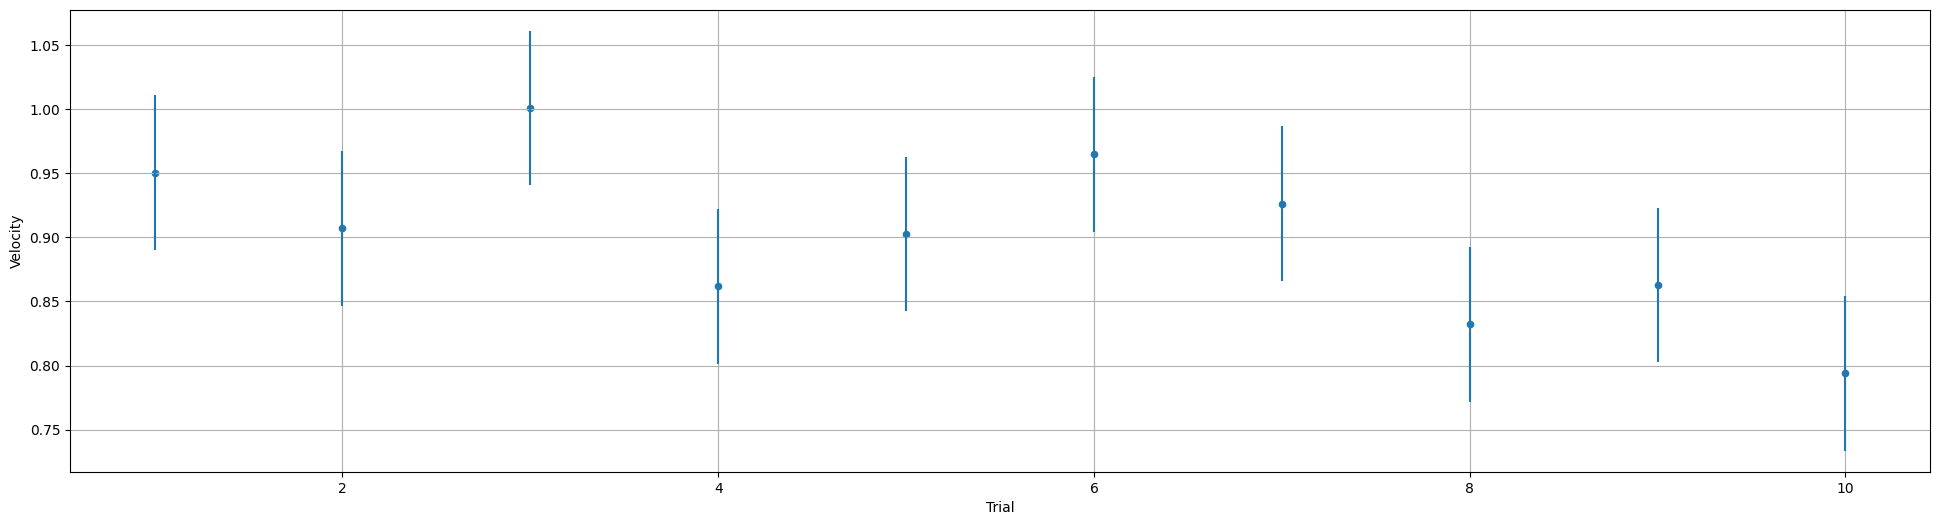

In [18]:
run_deg_computation(15, wf_table=WFS_FIFTEEN_DEG, verbose=[10])

## 20

In [19]:
WFS_TWENTY_DEG = {
}

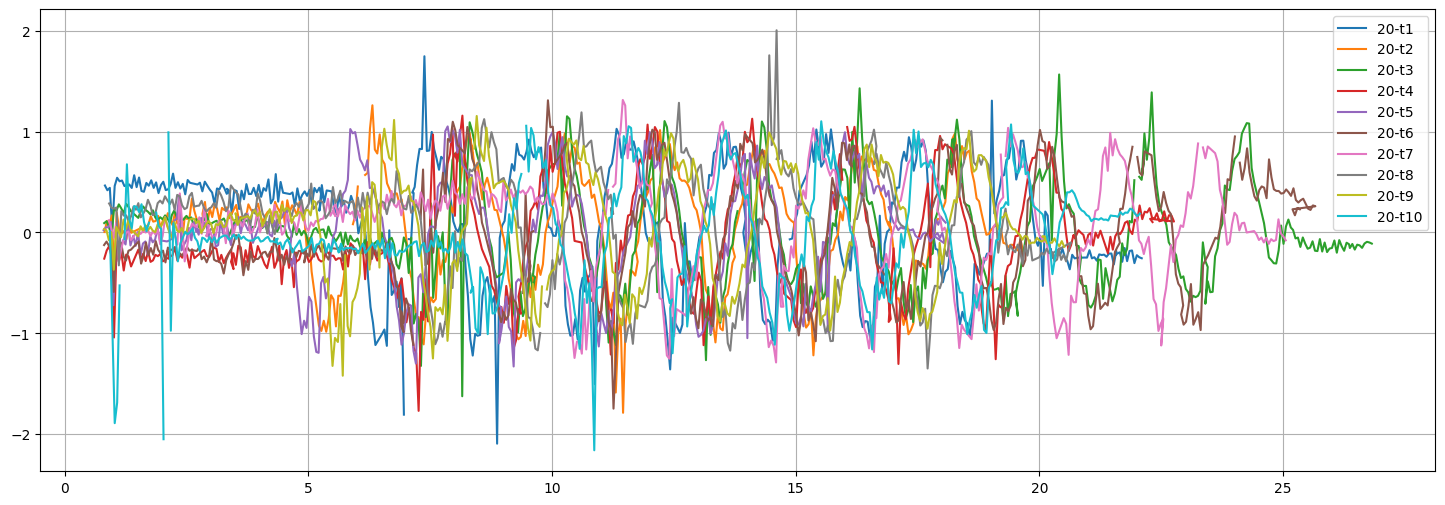

20-t1
[0.582457841, 0.2363605034, 0.159811156, 1.746027663, 0.9203557471, 0.1242222264, 1.026851142, 0.2204399447, 0.1008759661, 0.9887647081, 0.1337763385, 1.021176907, 0.1200864843, 0.9514908852, 1.306226694, 0.206277211]
[0.03740703789, -0.00907479048, -1.124624649, -1.806599848, -2.094184443, -0.03475353116, -1.504377117, -0.1022007775, -1.358126852, -0.4557883184, -0.3324127675, -1.073019707, -1.088229805, -0.6020327257, -1.026179934, -0.5298980451]
trial avg v: 1.3976960023099998
~~~~~~
20-t2
[0.1124091178, 0.1982017808, 0.03319836252, 0.01385389486, 0.1906818956, 0.3341514986, 1.260029786, 0.988250281, 0.9818554281, 1.013844665, 0.875225204, 0.8544243046, 0.01438370519, 0.9822450441, 0.08189928795]
[0.003911733867, -0.415156702, -0.01223729562, -0.06730064416, -0.003576661972, -0.08982173624, -0.9848394813, -1.11014648, -1.059725639, -1.788238723, -1.09047415, -1.21865627, -1.010055853, -0.1052963067, -0.02348531505]
trial avg v: 1.1493466466200002
~~~~~~
20-t3
[0.1112977943, 0.

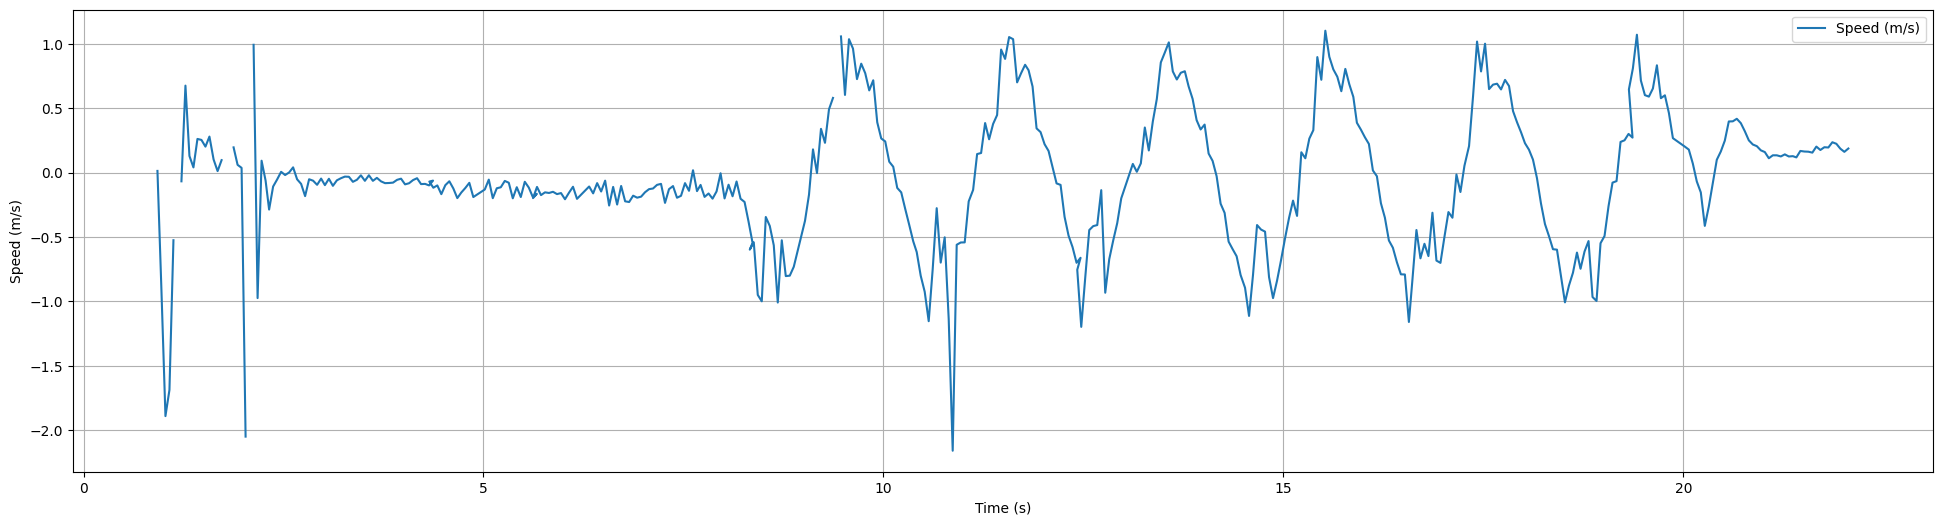

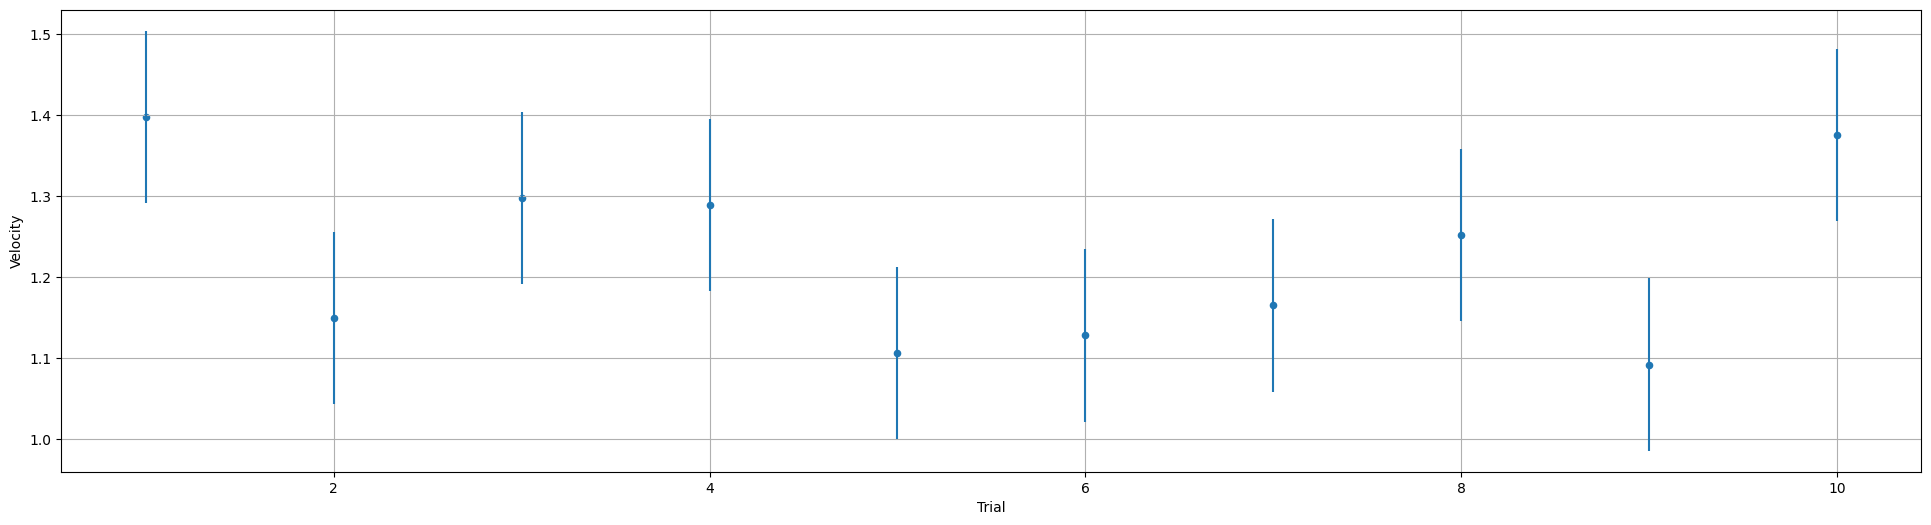

In [20]:
run_deg_computation(20, wf_table=WFS_TWENTY_DEG, verbose=[10])

## 25

In [21]:
WFS_TWENTYFIVE_DEG = {
}

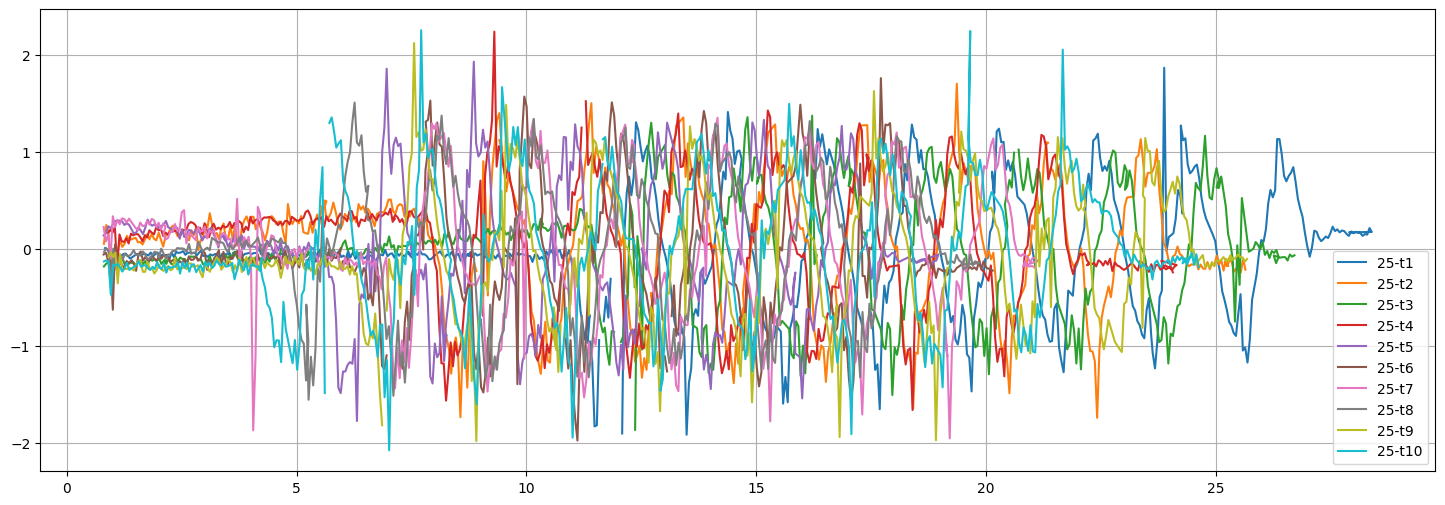

25-t1
[0.006898503121, 0.008480531767, 1.303951321, 1.410017041, 1.234470362, 1.280597458, 1.238166247, 1.186556484, 0.05207323831, 1.866268915, 1.131230158]
[-0.2142415497, -0.05747454938, -1.905181774, -1.918149393, -1.597658225, -1.654771417, -1.471582143, -1.273749733, -1.234130224, -0.02223082775, -1.174380047]
trial avg v: 1.5646343933999998
~~~~~~
25-t2
[0.2447590407, 0.2375757289, 0.5078609207, 0.9020905636, 1.39854515, 1.501344843, 1.354171371, 1.281670934, 1.27480687, 0.02528062361, 1.701934736, 1.097350996, 0.1190141299, 1.12953074, 0.005048219238]
[0.05060758532, -0.3636358836, -0.01342450597, -1.73762172, -0.4817258921, -1.290283778, -1.33098967, -1.386126904, -1.37341654, -0.02361994751, -1.646627617, -1.490376593, -0.1945218136, -1.743273254, -0.181134642]
trial avg v: 1.5241693122
~~~~~~
25-t3
[-0.02917098513, 0.006378407669, 0.05197272096, 0.08556644298, 0.008197814109, 0.00843551686, 0.1268145114, 0.4106999217, 0.4684546447, 0.3485074226, 1.299740856, 1.356673846, 0.1

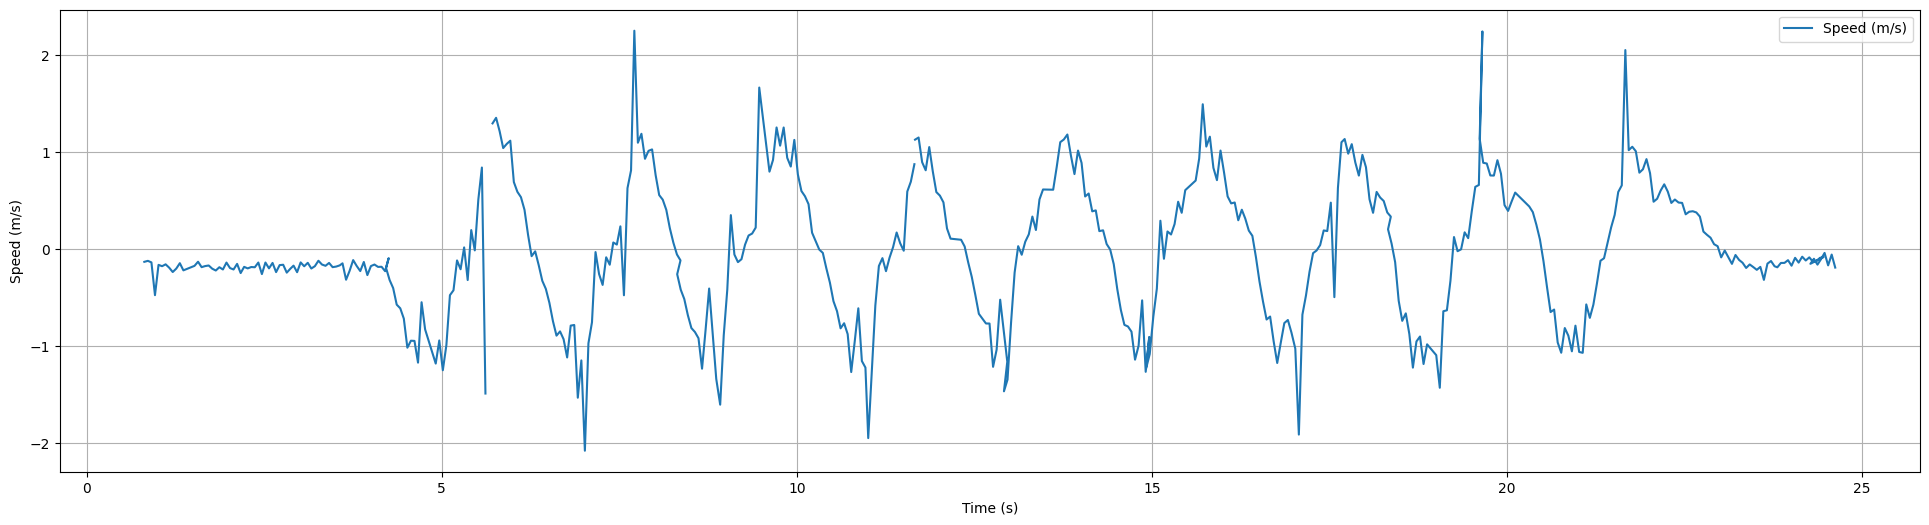

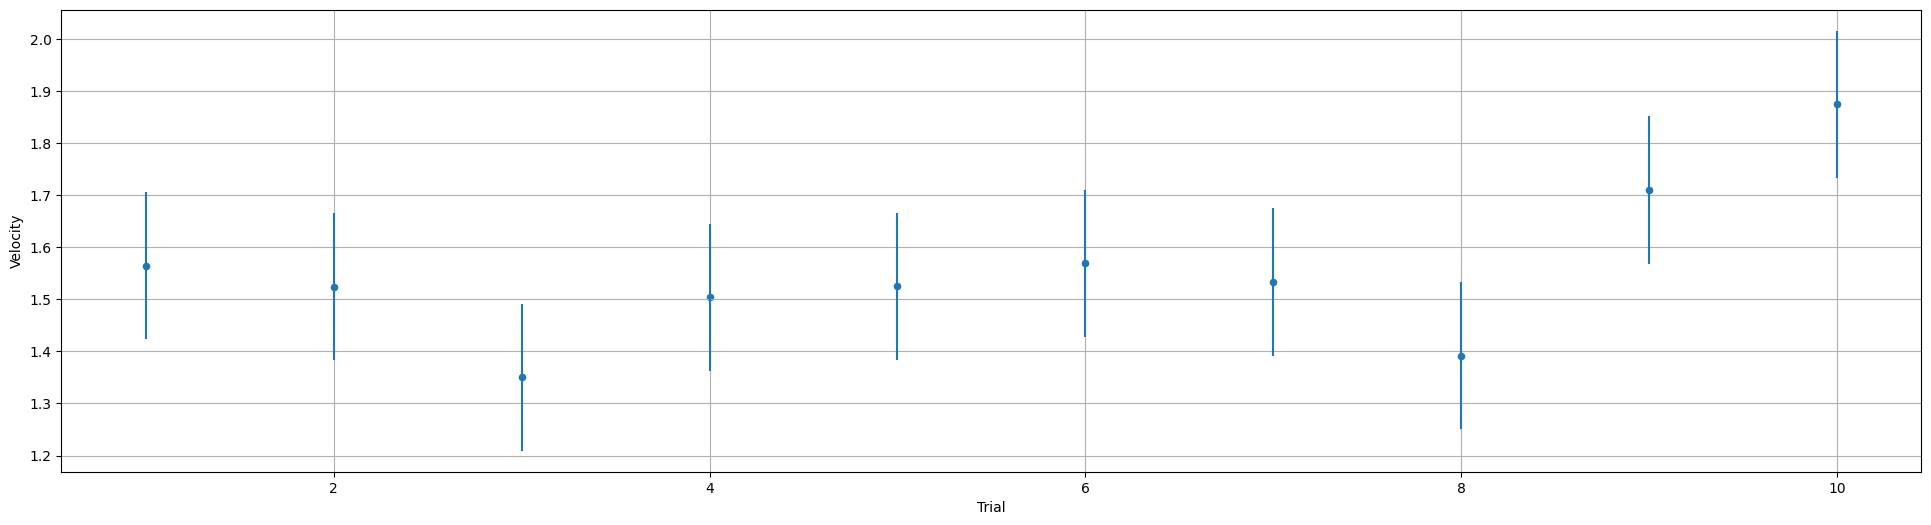

In [22]:
run_deg_computation(25, wf_table=WFS_TWENTYFIVE_DEG, verbose=[10])

## 30

In [23]:
WFS_THIRTY_DEG = {
    '30-t1': WaveFilter(x_min=8, x_max=19),
    '30-t2': WaveFilter(x_min=8, x_max=18),
    '30-t4': WaveFilter(x_min=10, x_max=20),
    '30-t5': WaveFilter(x_min=13, x_max=23),
    '30-t6': WaveFilter(x_min=8, x_max=21),
    '30-t7': WaveFilter(x_min=7, x_max=20, y_min=-2),
    '30-t8': WaveFilter(x_min=13, x_max=25),
    '30-t9': WaveFilter(x_min=13, x_max=25, y_min=-2),
    '30-t10': WaveFilter(x_min=10, y_min=-2),
}

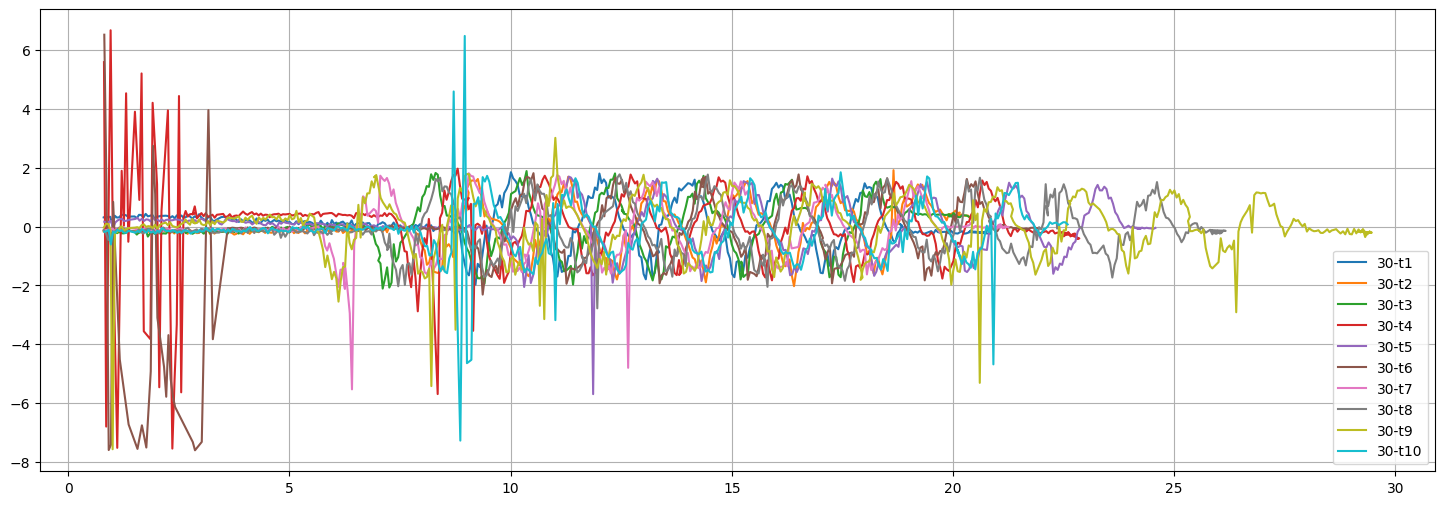

30-t1
[-0.0175078684134311, 0.0702845314980438, 0.0419826440025117, 0.0256300155932476, 1.84909024835283, 1.80396363142261, 1.59523501117145, 1.48852709317837, 1.47099470758815, 0.149343926683418]
[-0.0315836683645188, -0.0343016720016154, -0.15131592884694, -1.97357740624454, -0.56308888862084, -1.6984918565576, -1.79291037601086, -1.72148843392784, -1.58713914321408, -0.524060683712624]
trial avg v: 1.698141790766833
~~~~~~
30-t2
[1.61821534357903, 1.69366244087676, 0.0372612349066404, 1.59459125800289, 0.0807538206080083, 1.54560292007993, 0.120900802230133, 1.51830762332021]
[-1.57717325667387, -1.68696683725082, -1.79878877941381, -0.18189982566247, -1.89782516793553, -0.0093273267779725, -2.02699975345375, -0.153735968266826]
trial avg v: 1.6958133380586602
~~~~~~
30-t3
[-0.0080928676207614, 0.0427836602031451, 0.066319858516557, 0.100592208190615, 0.023920908180437, 0.049906048945596, 0.111679642486366, 0.0016955649009142, 0.0686853865535464, 0.0320948308887514, 1.82267629655609

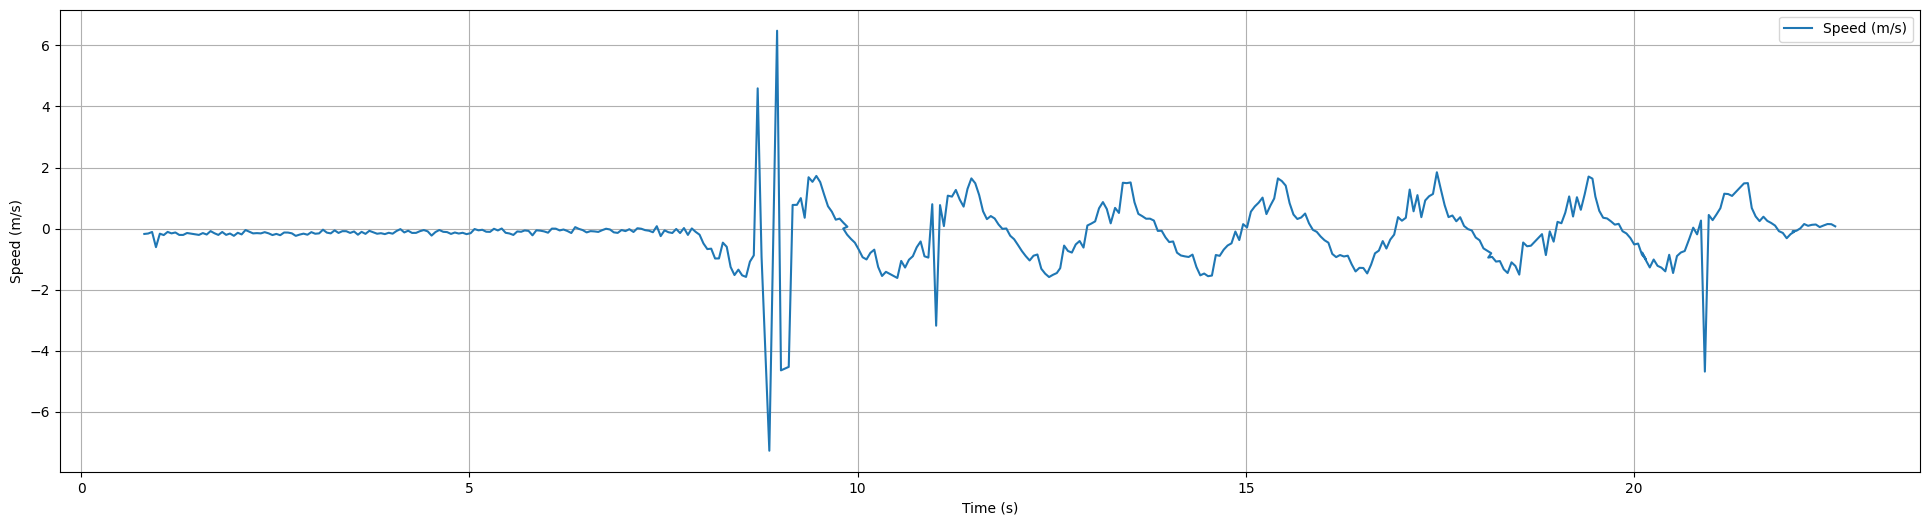

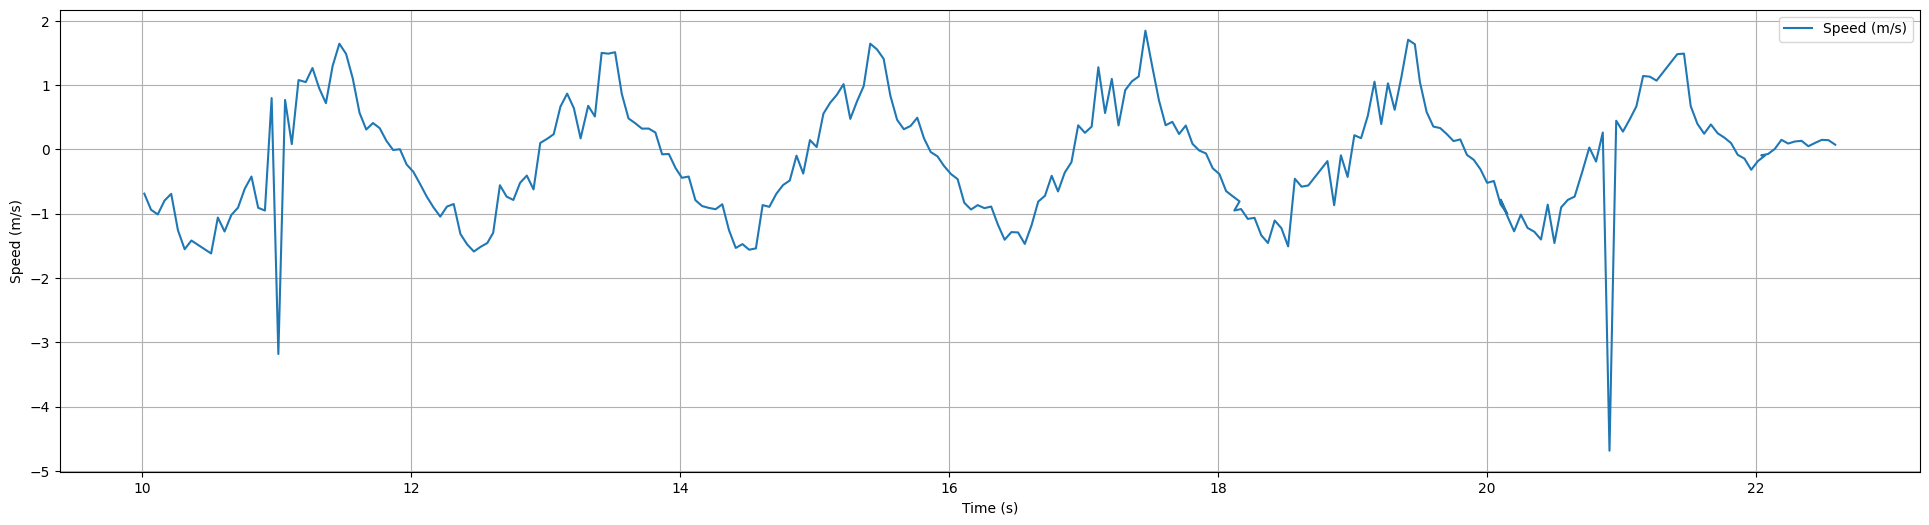

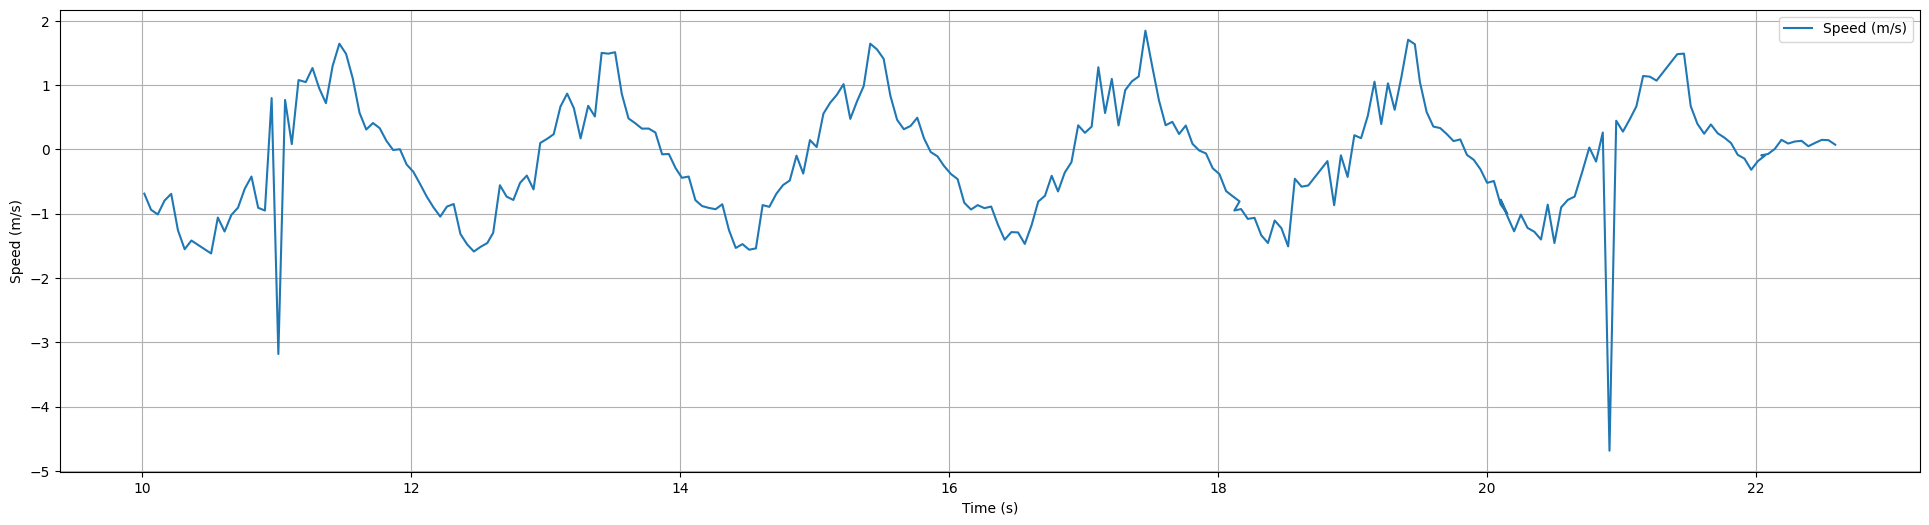

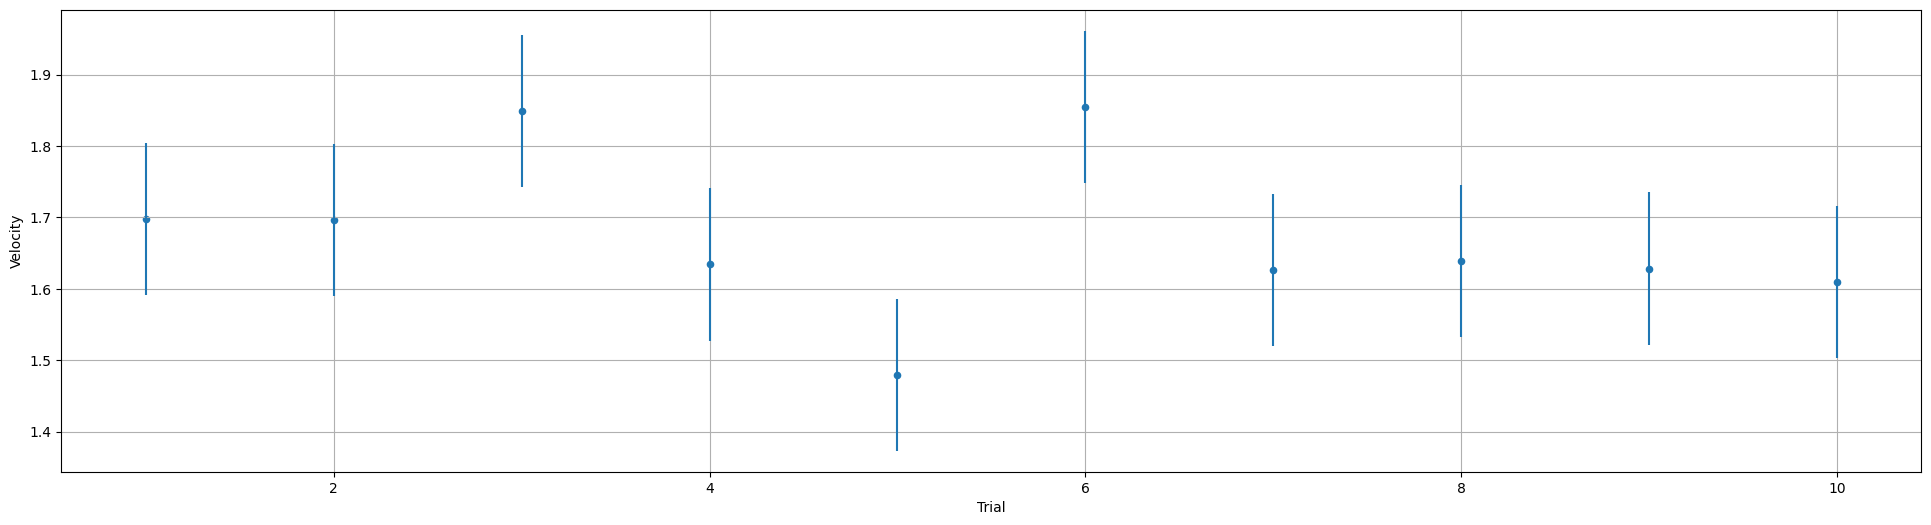

In [24]:
run_deg_computation(30, wf_table=WFS_THIRTY_DEG, verbose=[10])

## 35

In [25]:
WFS_THIRTYFIVE_DEG = {
}

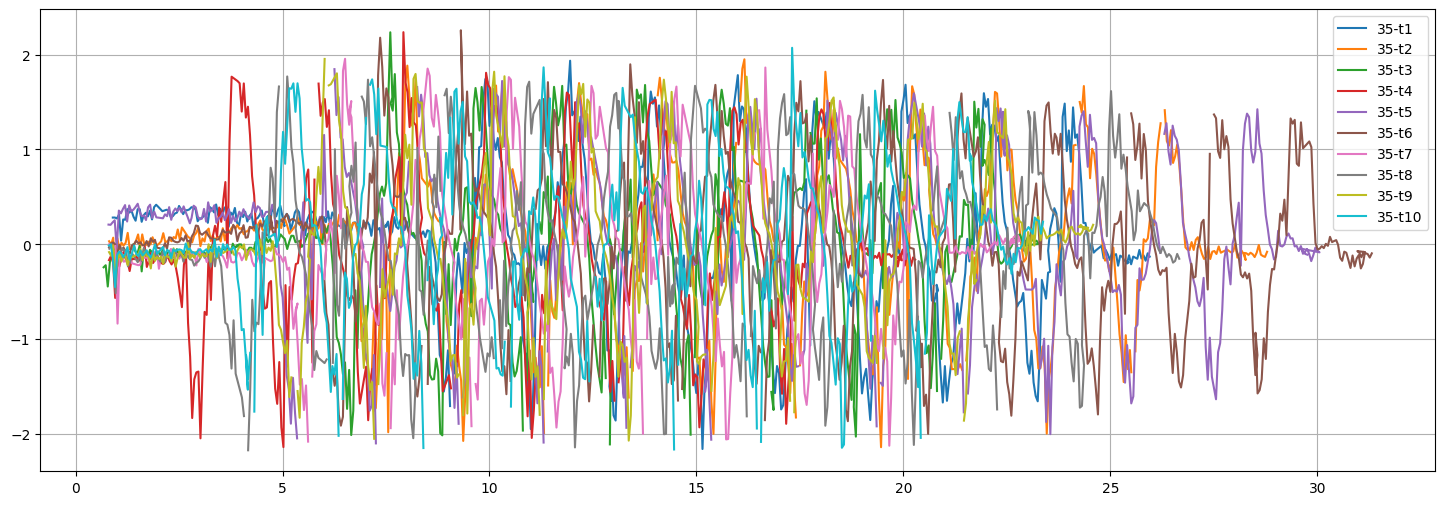

35-t1
[0.420190767, 0.07431357885, 0.01435733266, 1.742345606, 0.06034529664, 1.935747891, 0.03030341398, 0.8170857411, 1.610630659, 0.7491191285, 1.783732225, 0.5445636046, 1.508448085, 0.4263270453, 1.682202675, 0.06292474178, 0.05743642498, 1.59315662, 0.381201426, 1.483681866, 0.08849872388]
[0.01857605143, -1.704904387, -0.09202420615, -0.3078063282, -1.947119962, -0.2556264439, -1.857628489, -0.4287744092, -0.6179477356, -2.157424189, -0.5967826805, -1.74087571, -1.067239835, -1.852313833, -0.2564375826, -1.667326739, -0.1800292383, -0.07799175653, -1.654827738, -0.3939325315, -0.06195290522]
trial avg v: 1.8310021239
~~~~~~
35-t2
[0.03272207424, 0.07038158496, 0.06417013024, 0.0170062708, 0.1206609011, 0.1042879934, 0.1046946759, 0.02782205759, 0.1778700625, 0.3143104286, 1.883877546, 0.06970376061, 1.674410636, 0.6533905102, 1.699799241, 0.02277660731, 0.01316683268, 1.756204296, 0.3362680743, 1.950530971, 1.819340328, 0.03665891231, 0.5437152948, 1.666323343, 1.606677414, 1.66

/Users/nathanyeung/h4ck3r/datasci-studio/.venv/lib/python3.10/site-packages/matplotlib/axes/_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


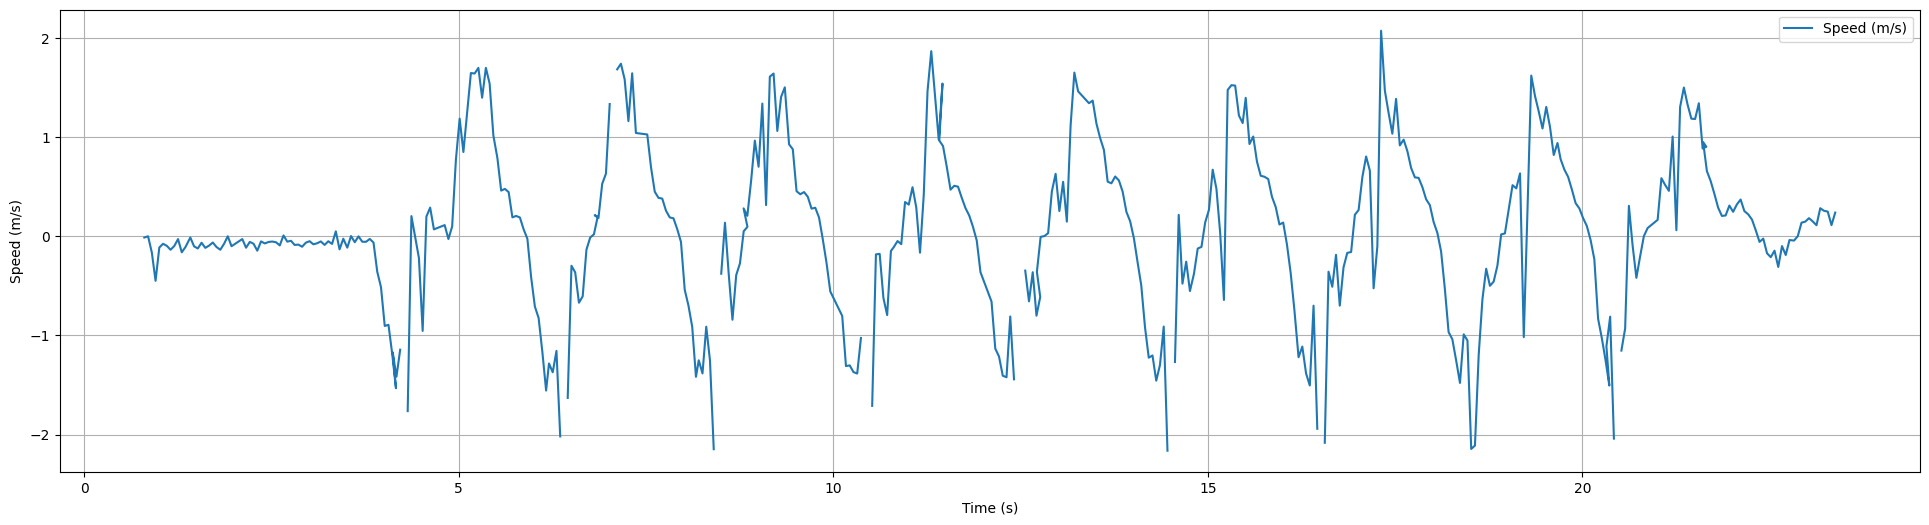

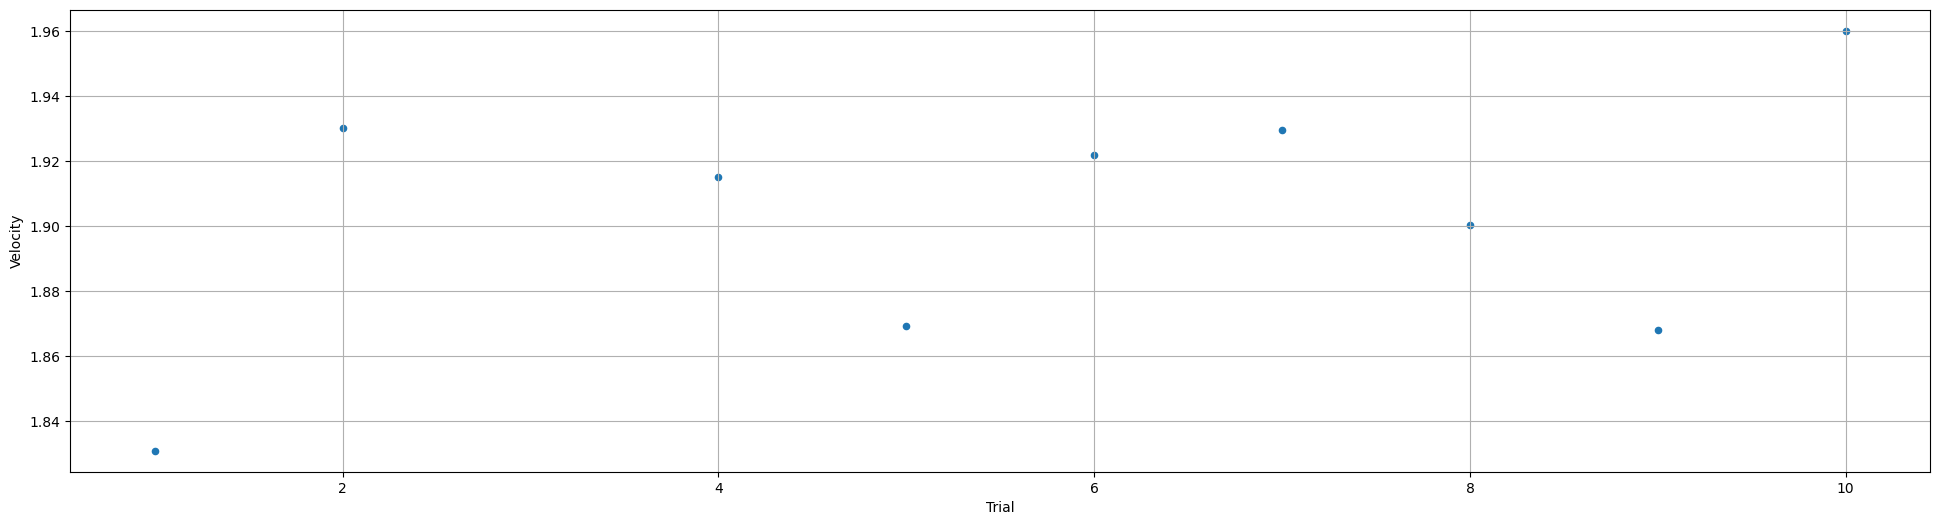

In [26]:
run_deg_computation(35, wf_table=WFS_THIRTYFIVE_DEG, verbose=[10])

## 40

In [27]:
WFS_FORTY_DEG = {
}

In [ ]:
run_deg_computation(40, wf_table=WFS_FORTY_DEG, verbose=[10])

## 45

In [ ]:
WFS_FORTYFIVE_DEG = {
    '45-t1': WaveFilter(x_min=7.5),
    '45-t2': WaveFilter(x_min=13, x_max=25),
    '45-t3': WaveFilter(x_min=7, x_max=17),
    '45-t4': WaveFilter(y_min=-4),
    '45-t5': WaveFilter(x_min=4),
    '45-t6': WaveFilter(x_min=10, x_max=22),
    '45-t7': WaveFilter(x_min=10, y_min=-4),
    '45-t8': WaveFilter(x_min=15),
    '45-t9': WaveFilter(x_min=7.5),
}

In [ ]:
run_deg_computation(45, wf_table=WFS_FORTYFIVE_DEG, verbose=[9])

## 60

Unfortunately, the $60^o$ angle proved too difficult to collect data for as the large angle caused some problems in our setup.

## Objective
- 4 angles, 10 samples for each = 40 total
- For each sample, find 5 highest crests + 5 lowest troughs
- absolute value all points
- avg all points

## Graphing
- one overall velocity vs degree line graph
- graph for each item of trials, with line for expected value

In [ ]:
results_df_setup = {
    'Angle': [5, 10, 15, 20, 25, 30, 35, 40, 45],
    'Avg. Velocity (m/s)': RESULTS,
    'Standard Deviation': STDEVS
}
master_results_df = pd.DataFrame(data=results_df_setup)
display(master_results_df)
plot_trial_dataframe(master_results_df, xlabel='Angle', ylabel='Avg. Velocity (m/s)', yerr=results_df_setup['Standard Deviation'])

## Reference links
- [pandas.DataFrame.plot — pandas 2.0.1 documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html)
- [matplotlib.pyplot.errorbar — Matplotlib 3.7.1 documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html#examples-using-matplotlib-pyplot-errorbar)
- [Errorbar limit selection — Matplotlib 3.7.1 documentation](https://matplotlib.org/stable/gallery/lines_bars_and_markers/errorbar_limits_simple.html#sphx-glr-gallery-lines-bars-and-markers-errorbar-limits-simple-py)